

> ## ⛹ XGBoost with K Fold Cross Validation without model ensemble  (Private Score 0.9658)



# 🔵 Downloading Data from credit risk model stability Kaggle competition

In [ ]:
!wget https://storage.googleapis.com/ss4-exp-datasource/datascience/home-credit-credit-risk-model-stability.zip
!unzip home-credit-credit-risk-model-stability.zip


🔵Downloading Test set from Super AI Kaggle competition

In [ ]:
from google.colab import userdata
username = userdata.get('KAGGLE_USER')
key = userdata.get('KAGGLE_KEY')
# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle competitions download -c home-credit-credit-risk-modeling
#!unzip /content/home-credit-credit-risk-model-stability.zip && rm -rf /content/home-credit-credit-risk-model-stability.zip

In [ ]:
!unzip /content/home-credit-credit-risk-modeling.zip

# 🔵 Install and Import Library

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
from pathlib import Path
import subprocess
import os
import gc
from glob import glob
import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import joblib
import warnings
from sklearn.base import BaseEstimator, RegressorMixin
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
warnings.filterwarnings('ignore')
ROOT = '/content/'
ROOT

'/content/'

# 🔵 Data Manipulation

In [ ]:
class Pipeline:
    """
    This class encapsulates data preprocessing functions for machine learning pipelines.
    """
    # Marks the method as a static method, not needing a class instance
    @staticmethod
    def set_table_dtypes(df):
        """
        Intelligently assigns appropriate data types to DataFrame columns.

        Args:
            df: The polars DataFrame to process.

        Returns:
            The DataFrame with updated column data types.
        """
        for col in df.columns:
             # Set certain columns to Int64 data type
             if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                  df = df.with_columns(pl.col(col).cast(pl.Int64))
             # Set 'date_decision' column to Date data type
             elif col in ["date_decision"]:
                  df = df.with_columns(pl.col(col).cast(pl.Date))
             # Set columns ending with 'P' or 'A' to Float64 data type
             elif col[-1] in ("P", "A"):
                  df = df.with_columns(pl.col(col).cast(pl.Float64))
             # Set columns ending with 'M' to Utf8 data type
             elif col[-1] in ("M",):
                  df = df.with_columns(pl.col(col).cast(pl.Utf8))
            # Set columns ending with 'D' to Date data type
             elif col[-1] in ("D",):
                  df = df.with_columns(pl.col(col).cast(pl.Date))
        return df


    @staticmethod
    def handle_dates(df):
        """
        Transforms date-related columns into numerical features.

        Args:
            df: The polars DataFrame to process.

        Returns:
            The DataFrame with transformed date features.
        """
        for col in df.columns:
          # Subtract 'date_decision' column from date columns
              if col[-1] in ("D",):
                  df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                  # Convert the result to total days
                  df = df.with_columns(pl.col(col).dt.total_days())
                  # Drop unnecessary date columns
                  df = df.drop("date_decision", "MONTH")
        return df



    @staticmethod
    def filter_cols(df):
        """
        Removes irrelevant or overly complex columns from the DataFrame.

        Args:
            df: The polars DataFrame to process.

        Returns:
            The DataFrame with filtered columns.
        """
        for col in df.columns:
              # Exclude specific columns and drop columns with Utf8 data type if they have few unique values
              if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.Utf8):
                    freq = df[col].n_unique()
              # Drop the column if it has only one unique value or more than 200 unique values
              if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        return df



In [ ]:
class Aggregator:
    """
    This class provides methods to generate aggregation expressions for different data types
    within a Polars DataFrame. The goal is to create features that capture different aspects
    of the underlying data for machine learning tasks.
    """

    @staticmethod
    def num_expr(df):
        """Generates aggregation expressions for numerical columns."""
        cols = [col for col in df.columns if col[-1] in ("P", "A")]  # Select columns ending in 'P' or 'A'
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]    # Calculate max
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]  # Calculate last value
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]  # Calculate mean
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]  # Calculate median
        expr_var = [pl.var(col).alias(f"var_{col}") for col in cols]     # Calculate variance

        return expr_max + expr_last + expr_mean  # Combine expressions, omitting some for brevity

    @staticmethod
    def date_expr(df):
        """Generates aggregation expressions for date columns."""
        cols = [col for col in df.columns if col[-1] in ("D")]  # Select columns ending in 'D'
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]  # Calculate max
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]  # Calculate last value
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]  # Calculate mean
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]  # Calculate median

        return expr_max + expr_last + expr_mean  # Combine expressions

    @staticmethod
    def str_expr(df):
        """Generates aggregation expressions for string columns."""
        cols = [col for col in df.columns if col[-1] in ("M",)]  # Select columns ending in 'M'
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]  # Calculate max (lexicographically)
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]  # Calculate last value

        return expr_max + expr_last

    @staticmethod
    def other_expr(df):
        """Generates aggregation expressions for other column types."""
        cols = [col for col in df.columns if col[-1] in ("T", "L")]  # Select columns ending in 'T' or 'L'
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]  # Calculate max
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]  # Calculate last value

        return expr_max + expr_last

    @staticmethod
    def count_expr(df):
        """Generates aggregation expressions for count columns."""
        cols = [col for col in df.columns if "num_group" in col]  # Select columns containing 'num_group'
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]  # Calculate max
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]  # Calculate last value
        return expr_max + expr_last

    @staticmethod
    def get_exprs(df):
        """Combines all aggregation expressions into a single list."""
        exprs = (Aggregator.num_expr(df) +
                 Aggregator.date_expr(df) +
                 Aggregator.str_expr(df) +
                 Aggregator.other_expr(df) +
                 Aggregator.count_expr(df))
        return exprs



## 🔵 Feature Engineering and Data Preprocessing

In [ ]:
import polars as pl
from glob import glob
import numpy as np

def read_file(path, depth=None):
    """
    Reads a parquet file into a Polars DataFrame and potentially aggregates it based on depth.

    Args:
        path (str): The path to the parquet file.
        depth (int, optional): The depth level for aggregation (1 or 2). Defaults to None.

    Returns:
        pl.DataFrame: The processed DataFrame.
    """
    df = pl.read_parquet(path)  # Read parquet file
    df = df.pipe(Pipeline.set_table_dtypes)  # Set correct data types

    if depth in [1, 2]:  # Aggregate if depth is 1 or 2
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))  # Aggregate by 'case_id'

    return df

def read_files(regex_path, depth=None):
    """
    Reads multiple parquet files matching a regex pattern, processes them, and concatenates them.

    Args:
        regex_path (str): A regex pattern to match file paths.
        depth (int, optional): The depth level for aggregation (1 or 2). Defaults to None.

    Returns:
        pl.DataFrame: The concatenated and processed DataFrame.
    """
    chunks = []  # Store processed DataFrames
    for path in glob(str(regex_path)):  # Iterate through matching files
        df = pl.read_parquet(path)  # Read parquet file
        df = df.pipe(Pipeline.set_table_dtypes)  # Set correct data types

        if depth in [1, 2]:  # Aggregate if depth is 1 or 2
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

        chunks.append(df)  # Append to the list

    df = pl.concat(chunks, how="vertical_relaxed")  # Concatenate all DataFrames
    df = df.unique(subset=["case_id"])  # Ensure unique rows based on 'case_id'
    return df


def feature_eng(df_base, depth_0, depth_1, depth_2):
    """
    Performs feature engineering on a base DataFrame by joining with aggregated DataFrames.

    Args:
        df_base (pl.DataFrame): The base DataFrame.
        depth_0 (list): List of DataFrames at depth 0.
        depth_1 (list): List of DataFrames at depth 1.
        depth_2 (list): List of DataFrames at depth 2.

    Returns:
        pl.DataFrame: The feature-engineered DataFrame.
    """
    # Create new features: month and weekday of decision date
    df_base = df_base.with_columns(
        month_decision=pl.col("date_decision").dt.month(),
        weekday_decision=pl.col("date_decision").dt.weekday(),
    )

    # Join aggregated DataFrames to the base DataFrame
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

    df_base = df_base.pipe(Pipeline.handle_dates)  # Handle dates in the DataFrame

    return df_base
#Categorical Conversion
def to_pandas(df_data, cat_cols=None):
    """
    Converts a Polars DataFrame to a Pandas DataFrame and handles categorical columns.

    Args:
        df_data (pl.DataFrame): The Polars DataFrame to convert.
        cat_cols (list, optional): List of columns to convert to categorical type. If None,
                                   all object columns are converted.

    Returns:
        pd.DataFrame: The converted Pandas DataFrame.
        list: The list of categorical columns.
    """
    df_data = df_data.to_pandas()  # Convert to Pandas

    if cat_cols is None:  # Find categorical columns if not specified
        cat_cols = list(df_data.select_dtypes("object").columns)

    df_data[cat_cols] = df_data[cat_cols].astype("category")  # Convert to categorical

    return df_data, cat_cols

In [ ]:
# Memory Optimization
def reduce_mem_usage(df):
    """
    Iterates through all the columns of a dataframe and modifies the data type
    to reduce memory usage.
    """

    # Print initial memory usage
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        # Determine column type
        col_type = df[col].dtype

        # Skip categorical columns
        if str(col_type) == "category":
            continue

        # Handle numeric columns
        if col_type != object:
            # Determine min and max values of the column
            c_min = df[col].min()
            c_max = df[col].max()

            # Process integer columns
            if str(col_type)[:3] == 'int':
                # Downcast to int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # Downcast to int16
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # Downcast to int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # Downcast to int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # Process float columns
            else:
                # Downcast to float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                # Downcast to float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # Leave as float64
                else:
                    df[col] = df[col].astype(np.float64)

    # Print final memory usage
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## 🔵 Train

## Train data preprocessing

In [ ]:
ROOT = Path("/content")
TRAIN_DIR = ROOT / "parquet_files" / "train"

data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
}

In [ ]:
# Feature engineering
df_train = feature_eng(**data_store)  # Apply feature engineering to the loaded datasets

# Memory Management: Delete the data_store dictionary and run garbage collection
del data_store
gc.collect()   # Explicitly free up memory

# Filter out irrelevant or overly complex columns
df_train = df_train.pipe(Pipeline.filter_cols)

# Convert to Pandas DataFrame and identify categorical columns
df_train, cat_cols = to_pandas(df_train)  # Convert for further processing with scikit-learn, etc.

# Optimize memory usage of the DataFrame by downcasting numeric columns
df_train = reduce_mem_usage(df_train)

# Get list of numerical columns for later use
nums = df_train.select_dtypes(exclude='category').columns

# Display the first 5 rows of the processed DataFrame for quick inspection
print(df_train.head().to_markdown(index=False, numalign='left', stralign='left'))


## Categorical columns normalization

In [ ]:
# Find columns that are either integers or floats
new_nums = df_train.select_dtypes(include=['int', 'float']).columns.tolist()

# Intersect these columns with the previously identified numerical columns (nums)
# to ensure we're only working with columns that were originally numeric before memory optimization
new_nums = set(new_nums).intersection(nums)

# Convert the set back to a list for further usage
new_nums = list(new_nums)


In [ ]:
# Find columns that are either of type 'object' (string) or 'category'
new_cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Intersect these columns with the previously identified categorical columns (cat_cols)
# to ensure we're only working with columns that were originally categorical
# and are still categorical after memory optimization
new_cat_cols = set(new_cat_cols).intersection(cat_cols)

# Convert the set back to a list for further usage
new_cat_cols = list(new_cat_cols)


In [ ]:
from itertools import combinations, permutations

# Group numerical columns based on the number of missing values they contain
nans_df = df_train[new_nums].isna()  # Create a DataFrame indicating which values are missing in each numeric column
nans_groups = {}

for col in new_nums:
    cur_group = nans_df[col].sum()  # Calculate the number of missing values in the column
    nans_groups.setdefault(cur_group, []).append(col)  # Add the column to the appropriate group in the dictionary (group key is the number of missing values)

# Encode categorical variables using ordinal encoding
encoder = OrdinalEncoder()
df_train[new_cat_cols] = encoder.fit_transform(df_train[new_cat_cols])  # Fit the encoder and transform the categorical columns

print(df_train.head().to_markdown(index=False, numalign='left', stralign='left'))  # Show the first 5 rows of the DataFrame for a quick look

## Downsampling over 250k added

In [ ]:
# Split the data into majority and minority classes
df_majority = df_train[df_train['target'] == 0]
df_minority = df_train[df_train['target'] == 1]

# Determine the number of samples for undersampling
n_minority = len(df_minority) + 250000  # 250k is added to address potential loss during later steps

# Random undersampling of the majority class
df_majority_undersampled = df_majority.sample(n=n_minority, random_state=888)  # Fixed random state for reproducibility

# Combine undersampled majority class with minority class
df_train_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the rows of the balanced dataset
df_train_balanced = df_train_balanced.sample(frac=1, random_state=157).reset_index(drop=True)  # Shuffle and reset index

print(df_train_balanced.head().to_markdown(index=False, numalign='left', stralign='left'))  # Show the first 5 rows of the balanced DataFrame


## 🔵 NULL values manipulation (private score 0.9219)

1.   KNN Imputation using Annoy
2.   Features dropout



In [ ]:
# count null
percent_missing = df.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing}, index=df_train.columns)
missing_value_df

## Import and Install libraries

In [ ]:
!pip install annoy

In [ ]:
import annoy
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook


In [ ]:
tqdm.pandas(desc="Imputing")

# def impute_with_annoy(column, annoy_index, k=5):
#     """
#     Imputes missing values in a column using Annoy's approximate nearest neighbors.

#     Args:
#         column (pd.Series): The column to impute.
#         annoy_index (annoy.AnnoyIndex): The Annoy index built on the features.
#         k (int, optional): The number of nearest neighbors to use for imputation. Defaults to 5.

#     Returns:
#         list: The imputed values for the column.
#     """
#     column_values = column.values
#     imputed_values = []

#     for i in range(len(column_values)):
#         if np.isnan(column_values[i]):
#             nn_indices = annoy_index.get_nns_by_item(i, k + 1)[1:]  # Exclude the point itself
#             nn_values = column_values[nn_indices]
#             imputed_values.append(np.nanmean(nn_values))  # Impute with mean of neighbors
#         else:
#             imputed_values.append(column_values[i])  # Keep existing value
#     return imputed_values


def impute_with_annoy(column, annoy_index, k=5, categorical_handling='most_frequent'):
    """
    Imputes missing values in a column using Annoy's approximate nearest neighbors.

    Args:
        column (pd.Series): The column to impute.
        annoy_index (annoy.AnnoyIndex): The Annoy index built on the features.
        k (int, optional): The number of nearest neighbors to use for imputation. Defaults to 5.
        categorical_handling (str, optional): How to handle categorical columns.
                                              'most_frequent' (default) replaces with the most frequent value,
                                              'drop' drops the column if it's categorical.

    Returns:
        list: The imputed values for the column.
    """
    column_values = column.values
    imputed_values = []

    for i in range(len(column_values)):
        if pd.isna(column_values[i]):  # Check for missing values using pd.isna
            if column.dtype == 'object' and categorical_handling == 'drop':  # Handle categorical column
                return None

            nn_indices = annoy_index.get_nns_by_item(i, k + 1)[1:]
            nn_values = column_values[nn_indices]

            if column.dtype == 'object':
                imputed_values.append(max(set(nn_values), key=list(nn_values).count))  # Impute with most frequent category
            else:
                imputed_values.append(np.nanmean(nn_values))  # Impute with mean of neighbors for numeric columns
        else:
            imputed_values.append(column_values[i])
    return imputed_values

In [ ]:
# List of columns to impute
columns_to_impute = ["max_last180dayaveragebalance_704A", "birthdate_574D", "contractssum_5085716L",
                     "max_last30dayturnover_651A", "max_pmts_pmtsoverdue_635A", "max_pmts_date_1107D",
                     "max_num_group1_10", "max_num_group2", "max_num_group1_11", "assignmentdate_238D",
                     "assignmentdate_4527235D", "assignmentdate_4955616D",
                     "weekday_decision", "month_decision"]

# Create DataFrame with columns to impute
X_impute = df_train_balanced[columns_to_impute].copy()


# Build Annoy index for fast nearest neighbor search
t = annoy.AnnoyIndex(X_impute.shape[1], 'euclidean')
for i in tqdm(range(X_impute.shape[0]), desc="Building Annoy Index"):
    row = X_impute.iloc[i].values
    t.add_item(i, row)
# Build with 10 trees for better accuracy
t.build(10)


# Perform KNN imputation using Annoy
X_imputed = X_impute.progress_apply(lambda x: impute_with_annoy(x, t, k=5))


# Replace missing values in the original DataFrame
df_train_balanced[columns_to_impute] = X_imputed

print(df_train_balanced.head()) # Print the first 5 rows of the dataframe


In [ ]:
#calculate null values before balancing data
null_before = df_train[columns_to_impute].isnull().sum()
null_before

In [ ]:
#calculate null values after balancing data
null_counts = df_train_balanced[columns_to_impute].isnull().sum()
null_counts


## Features to impute according to LightGBM feature importance

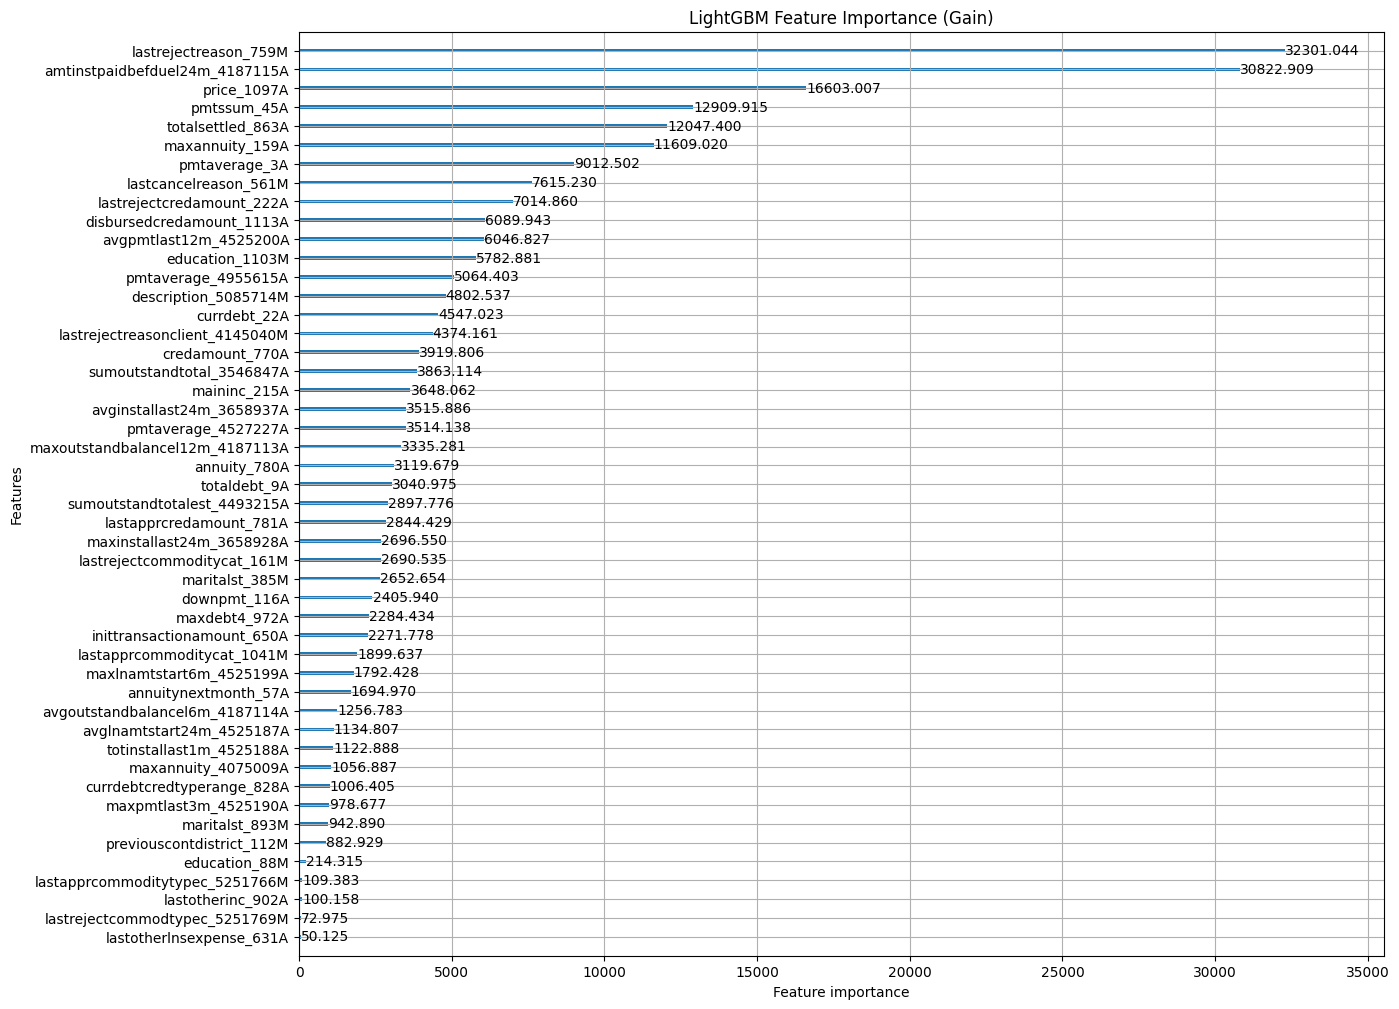


In [ ]:
columns_to_impute_2 = ['lastrejectreason_759M',
            'amtinstpaidbefduel24m_4187115A',
            'price_1097A',
            'pmtssum_45A',
            'totalsettled_863A',
            'maxannuity_159A',
            'pmtaverage_3A',
            'lastcancelreason_561M',
            'lastrejectcredamount_222A',
            'disbursedcredamount_1113A',
            'avgpmtlast12m_4525200A',
            'education_1103M',
            'pmtaverage_4955615A',
            'description_5085714M',
            'currdebt_22A',
            'lastrejectreasonclient_4145040M',
            'credamount_770A',
            'sumoutstandtotal_3546847A',
            'maininc_215A',
            'avginstallast24m_3658937A',
            'pmtaverage_4527227A',
            'maxoutstandbalancel12m_4187113A',
            'annuity_780A',
            'totaldebt_9A',
            'sumoutstandtotalest_4493215A',
            'lastapprcredamount_781A',
            'maxinstallast24m_3658928A',
            'lastrejectcommoditycat_161M',
            'maritalst_385M',
            'downpmt_116A',
            #"classificationofcontr_1114M",
            'maxdebt4_972A',
            'inittransactionamount_650A',
            'lastapprcommoditycat_1041M',
            #'maxinamtstart6m_4525199A',
            'annuitynextmonth_57A',
            'avgoutstandbalancel6m_4187114A',
            #'avgin_121A',
            #'ginamtstart24m_4525187A',
            #'totinstallast12m_4525188A',
            'maxannuity_4075009A',
            'currdebtcredtyperange_828A',
            'maxpmtlast3m_4525190A',
            'maritalst_893M',
            #'previouscontdis_1083A',
            #'district_112M',
            'education_88M',
            #'lastapprcommoditytypec_5251766M',
            'lastotherinc_902A',
            'lastrejectcommodtypec_5251769M',
            #'lastotherincexpense_631A'
            ]


# Create DataFrame with columns to impute
X_impute_2 = df_train_balanced[columns_to_impute_2].copy()

# Convert all columns to numeric if possible
for col in X_impute_2.columns:
    try:
        X_impute_2[col] = pd.to_numeric(X_impute_2[col])
    except ValueError:
        pass

# Handle categorical columns by dropping columns which are not numeric
X_impute_2 = X_impute_2.select_dtypes(include=[np.number])
columns_to_impute_2 = X_impute_2.columns.tolist()


# Build Annoy index for fast nearest neighbor search
t_2 = annoy.AnnoyIndex(X_impute_2.shape[1], 'euclidean')
for i in tqdm(range(X_impute_2.shape[0]), desc="Building Annoy Index (2)"):
    row = X_impute_2.iloc[i].values
    t_2.add_item(i, row)
t_2.build(10)  # Build with 10 trees


# Perform KNN imputation using Annoy and handle categorical columns
X_imputed_2 = X_impute_2.progress_apply(lambda x: impute_with_annoy(x, t_2, k=5, categorical_handling='drop'))

# Drop columns where all values are nan (meaning the column was dropped during imputation)
X_imputed_2 = X_imputed_2.dropna(axis=1, how='all')

# Replace missing values in the original DataFrame
df_train_balanced[X_imputed_2.columns] = X_imputed_2

print(df_train_balanced.head())

In [ ]:
null_before = df_train[columns_to_impute_2].isnull().sum()
null_before

In [ ]:
null_counts = df_train_balanced[columns_to_impute_2].isnull().sum()
null_counts


In [ ]:
import annoy
from tqdm.auto import tqdm
tqdm.pandas(desc="Imputing")

# Define columns to impute (columns_to_impute_3)
columns_to_impute_3 = [
    'pmtaverage_4955615A',
    'inittransactionamount_650A',
    'lastotherinc_902A',
    'contractssum_5085716L',
    'max_last30dayturnover_651A',
    'max_pmts_pmtsoverdue_635A',
    'max_pmts_date_1107D',
    'max_num_group1_10',
    'max_num_group2',
    'max_num_group1_11',
    'assignmentdate_238D',
    'assignmentdate_4527235D',
    'assignmentdate_4955616D'
]

# Create a copy of the relevant columns from df_train_balanced
X_impute_3 = df_train_balanced[columns_to_impute_3].copy()

# Convert all columns to numeric if possible. If a column cannot be converted to numeric (e.g., contains non-numeric values),
# it will be excluded from the imputation process.
for col in X_impute_3.columns:
    try:
        X_impute_3[col] = pd.to_numeric(X_impute_3[col])
    except ValueError:
        # Drop the column if it cannot be converted to numeric
        X_impute_3 = X_impute_3.drop(col, axis=1)
        columns_to_impute_3.remove(col)  # Also remove from the list of columns to impute
        print(f"Column '{col}' dropped due to non-numeric values.")

# Build an Annoy index for efficient nearest neighbor search
t_3 = annoy.AnnoyIndex(X_impute_3.shape[1], 'euclidean')
for i in tqdm(range(X_impute_3.shape[0]), desc="Building Annoy Index (3)"):
    row = X_impute_3.iloc[i].values
    t_3.add_item(i, row)
t_3.build(10)


# Impute the missing values using the defined function and the built Annoy index
X_imputed_3 = X_impute_3.progress_apply(lambda x: impute_with_annoy(x, t_3, k=5))

# Replace the NaN values in the original dataframe with the imputed values
df_train_balanced[X_imputed_3.columns] = X_imputed_3

print(df_train_balanced.head().to_markdown(index=False, numalign='left', stralign='left'))  # Print the first 5 rows


In [ ]:
null_before = df_train_balanced[columns_to_impute_2].isnull().sum()
null_before

In [ ]:
null_counts = df_train_balanced[columns_to_impute_3].isnull().sum()
null_counts


## Outlier Visualization

In [ ]:
import seaborn as sns

# Sample a few columns for a pairplot
sampled_columns = df_train_cleaned.select_dtypes(include='number').sample(5, axis=1).columns  # Select 5 random numeric columns
sns.pairplot(df_train_cleaned[sampled_columns])
plt.show()


In [ ]:
# Calculate null counts for each column in df_train_balanced
null_counts = df_train_balanced.isnull().sum()

# Sort null counts in descending order
null_counts = null_counts.sort_values(ascending=False)

# Filter for columns with null counts > 300,000
filtered_nulls = null_counts[null_counts > 300000]

# Convert to list and print
columns_with_many_nulls = filtered_nulls.index.tolist()
print(columns_with_many_nulls)

In [ ]:
from scipy import stats
import numpy as np


# Get all columns with missing values
cols_with_missing = df_train_balanced.columns[df_train_balanced.isnull().any()].tolist()

# Calculate absolute z-scores for all columns with missing values
z_scores = np.abs(stats.zscore(df_train_balanced[cols_with_missing]))

# Set the threshold for outlier detection (e.g., 2 standard deviations)
threshold = 2

# Identify rows where at least one column has a z-score exceeding the threshold
outliers = (z_scores > threshold).any(axis=1)


print("Rows with outliers:")
print(df_train_balanced[outliers])
print(len(df_train_balanced[outliers]))

## Nans columns manipulation

In [ ]:
# Create DataFrame with columns to impute
X_impute = df_train_balanced[columns_with_many_nulls].copy()


# Build Annoy index
t = annoy.AnnoyIndex(X_impute.shape[1], 'euclidean')  # Euclidean distance
for i in tqdm(range(X_impute.shape[0]), desc="Building Annoy Index"):
    row = X_impute.iloc[i].values
    t.add_item(i, row)
t.build(10)  # 10 trees

# KNN Impute with progress_apply and the defined function
X_imputed = X_impute.progress_apply(lambda x: impute_with_annoy(x, t, k=5))

# Replace NaN values
df_train_balanced[columns_with_many_nulls] = X_imputed

df_train_balanced

In [ ]:
# Convert halffloat columns to float32
for col in df_train_balanced.select_dtypes(include='float16'):
    df_train_balanced[col] = df_train_balanced[col].astype('float32')

# Now save to Parquet
df_train_balanced.to_parquet('train_df_balanced.parquet', partition_cols=['target'])


In [ ]:
df_train_balanced.loc[:, df_train_balanced.isnull().sum().sort_values() > 100000].columns


In [ ]:
df_features = pd.read_csv("/content/feature_definitions.csv")
df_features

In [ ]:
# Select columns with more than 50000 null values
selected_columns = df_train_cleaned.loc[:, df_train_cleaned.isnull().sum().sort_values() > 50000].columns

selected_columns = pd.DataFrame(selected_columns, columns=['Nan_Columns'])

selected_columns

In [ ]:
# Merge the DataFrames
merged_df = pd.merge(df_features, selected_columns, left_on='Variable', right_on='Nan_Columns', how='inner')

# Select and rename columns
result_df = merged_df[['Nan_Columns', 'Description']].rename(columns={'Nan_Columns': 'Nan_Columns_over50k'})

result_df

In [ ]:
result_df.to_csv("res.csv")

In [ ]:
nan_counts = {}
for col in result_df['Nan_Columns_over50k']:
    nan_counts[col] = df_train_cleaned[col].isnull().sum()
    print(f"{col}: {nan_counts[col]}")


## 🔵 Test

In [ ]:
ROOT_Test = Path("/content")
TEST_DIR = ROOT_Test /"parquet_files"/ "test"

data_store = {
    "df_base": read_files(Path("/content/parquet_files/test/test_base.parquet")),
    "depth_0": [read_files(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_files(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_files(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_files(TEST_DIR / "test_other_1.parquet", 1),
        read_files(TEST_DIR / "test_person_1.parquet", 1),
        read_files(TEST_DIR / "test_deposit_1.parquet", 1),
        read_files(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_files(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ]
}

In [ ]:
df_test = feature_eng(**data_store)
del data_store
gc.collect()
df_test = df_test.pipe(Pipeline.filter_cols)
df_test, cat_cols = to_pandas(df_test)
df_test = reduce_mem_usage(df_test)
df_test


In [ ]:
indexx = df_test['case_id']
indexx

0    57549
1    57543
2    57552
3    57631
4    57633
5    57569
6    57632
7    57630
8    57634
9    57551
Name: case_id, dtype: int32

In [ ]:
train_columns = set(df_train.columns)
test_columns = set(df_test.columns)

# Find common columns
common_columns = train_columns.intersection(test_columns)
print(f"Columns present in both train and test datasets: {common_columns}")

# Find columns in test but not in train
test_only_columns = test_columns - train_columns
print(f"Columns present only in the test dataset: {test_only_columns}")

# Find columns in train but not in test
train_only_columns = train_columns - test_columns
print(f"Columns present only in the train dataset: {train_only_columns}")

In [ ]:
# Iterate over each column in the DataFrame
for col in df_test.columns:
    # Check if the column data type is 'object' (categorical)
    if df_test[col].dtype == 'object':
        # Convert the column to string type, then fill missing values with '-1'
        df_test[col] = df_test[col].astype('str').fillna(df_test.median(), inplace=True)

# Initialize an OrdinalEncoder to encode categorical variables
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder to the categorical columns in the DataFrame
encoder.fit(df_test[cat_cols])

# Transform the categorical columns using the fitted encoder
df_test[cat_cols] = encoder.transform(df_test[cat_cols])

# Display the DataFrame after encoding
df_test


In [ ]:
# Iterate over each column in the DataFrame
for col in df_test.columns:
    # Check if the column data type is 'object' (categorical)
    if df_test[col].dtype == 'object':
        # Convert the column to categorical type and then encode the categories into numerical codes
        df_test[col] = df_test[col].astype('category').cat.codes
#df_test = df_test.drop(columns=['case_id'])

# Reduce memory usage of the DataFrame
df_test = reduce_mem_usage(df_test)

# Display the DataFrame after conversion and memory reduction
df_test


In [ ]:
df_test["debt-to-income"] = df_test["totaldebt_9A"] / df_test["maininc_215A"]
df_test

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,mean_pmts_dpdvalue_108P,mean_pmts_pmtsoverdue_635A,max_pmts_date_1107D,last_pmts_date_1107D,mean_pmts_date_1107D,max_num_group1_11,max_num_group2,last_num_group1_11,last_num_group2,debt-to-income
0,57549,100,1,1,NaN,NaN,-1352.0,NaN,1.563078e+06,-22723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.241777
1,57543,100,5,5,NaN,NaN,NaN,NaN,1.513640e+05,-14804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357482
2,57552,100,11,5,NaN,NaN,-740.0,NaN,7.470318e+05,-23768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57631,100,6,6,NaN,NaN,NaN,NaN,4.803345e+05,-12999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57633,100,1,2,NaN,NaN,NaN,NaN,6.373008e+06,-10496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,57569,100,12,1,NaN,NaN,-3720.0,NaN,NaN,-26408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
6,57632,100,2,6,NaN,NaN,-2264.0,NaN,1.767700e+04,-23107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
7,57630,100,3,2,NaN,NaN,NaN,NaN,4.999750e+05,-19767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
8,57634,100,1,3,NaN,NaN,NaN,NaN,1.526365e+04,-16281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
9,57551,100,11,5,NaN,NaN,NaN,NaN,2.926195e+06,-14090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## Train data downloading for easier use

In [ ]:
import pandas as pd
df_train_balanced = pd.read_parquet("/content/unimputed_train_df.parquet")
df_train_balanced

In [ ]:
df_train_balanced.describe()

In [ ]:
df_train_balanced.info()

In [ ]:
category_cols = df_train_balanced.select_dtypes(include='category').columns

# Check if there's exactly one category column
if len(category_cols) == 1:
    category_col = category_cols[0]
    print(f"Category column: {category_col}")

In [ ]:
df_train_balanced['target']

## Save to pkl

In [ ]:
len(df_train_balanced[df_train_balanced['target'] == 1]), len(df_train_balanced[df_train_balanced['target'] == 0])

(239938, 1740002)

In [ ]:
#df_train_balanced = df_train_cleaned.copy()

Downsampling อีกรอบ เพราะ data imbalance เกินไป




In [ ]:
df_majority = df_train_balanced[df_train_balanced['target'] == 0]
df_minority = df_train_balanced[df_train_balanced['target'] == 1]
n_minority = len(df_minority) + 30000
df_majority_undersampled = df_majority.sample(n=n_minority, random_state=27)
df_train_balanced = pd.concat([df_majority_undersampled, df_minority])
df_train_balanced = df_train_balanced.sample(frac=3, random_state=42, replace=True).reset_index(drop=True)
df_train_balanced

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,...,mean_pmts_dpdvalue_108P,mean_pmts_pmtsoverdue_635A,max_pmts_date_1107D,last_pmts_date_1107D,mean_pmts_date_1107D,max_num_group1_11,max_num_group2,last_num_group1_11,last_num_group2,debt-to-income
0,625353,4,0,2,7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1697164,50,0,12,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,1641659,46,0,11,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.386292
3,993080,75,1,6,1,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2605464,30,0,8,1,-2336.0,NaN,NaN,-21712.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529623,1574629,40,0,10,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1529624,1901008,85,1,8,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1529625,1758943,55,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1529626,1356176,17,1,4,2,NaN,NaN,NaN,-9704.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [ ]:
len(df_train_balanced[df_train_balanced['target'] == 1]), len(df_train_balanced[df_train_balanced['target'] == 0])

(720113, 809515)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Now you can save directly
df_train_balanced.to_parquet("/content/drive/MyDrive/unimputed_train_df_2.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
y = df_train_balanced["target"]
df_train_balanced = df_train_balanced.drop(columns=["target", "case_id", "WEEK_NUM"])
df_train_balanced = reduce_mem_usage(df_train_balanced)
df_train_balanced

,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,...,mean_pmts_dpdvalue_108P,mean_pmts_pmtsoverdue_635A,max_pmts_date_1107D,last_pmts_date_1107D,mean_pmts_date_1107D,max_num_group1_11,max_num_group2,last_num_group1_11,last_num_group2,debt-to-income
0,7,7,NaN,NaN,NaN,-8864.0,NaN,-8864.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,2,NaN,NaN,NaN,NaN,NaN,-22448.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,NaN,NaN,NaN,NaN,NaN,-21536.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.393799
3,2,6,NaN,NaN,NaN,NaN,NaN,-18992.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,1,NaN,NaN,NaN,NaN,NaN,-20576.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529623,11,5,NaN,NaN,NaN,NaN,NaN,-12200.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1529624,5,5,NaN,NaN,NaN,NaN,NaN,-14352.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1529625,2,7,-2560.0,NaN,NaN,-21920.0,NaN,-21920.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529626,3,6,NaN,NaN,NaN,NaN,NaN,-8720.0,-8720.0,4.0,...,3561.689697,0.589844,1.0,1.0,NaN,1.0,28.0,1.0,28.0,0.000000


In [ ]:
df_test.shape, df_train_balanced.shape

((10, 777), (1529628, 759))

In [ ]:
df_test

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,last_subjectrole_326M,max_subjectrole_43M,last_maritalst_703L,last_credacc_status_367L,last_periodicityofpmts_997M,maritalst_893M,max_credor_3940957M,last_pmtmethod_731M,last_credor_3940957M,cardtype_51L
0,57633,100,1,2,NaN,NaN,NaN,NaN,6.373008e+06,-10496,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,57551,100,11,5,NaN,NaN,NaN,NaN,2.926195e+06,-14090,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,57569,100,12,1,NaN,NaN,-3720.0,NaN,NaN,-26408,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,57634,100,1,3,NaN,NaN,NaN,NaN,1.526365e+04,-16281,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,57549,100,1,1,NaN,NaN,-1352.0,NaN,1.563078e+06,-22723,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,57631,100,6,6,NaN,NaN,NaN,NaN,4.803345e+05,-12999,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,57543,100,5,5,NaN,NaN,NaN,NaN,1.513640e+05,-14804,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,57630,100,3,2,NaN,NaN,NaN,NaN,4.999750e+05,-19767,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,57632,100,2,6,NaN,NaN,-2264.0,NaN,1.767700e+04,-23107,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,57552,100,11,5,NaN,NaN,-740.0,NaN,7.470318e+05,-23768,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
joblib.dump((df_train_balanced, y, df_test), 'data.pkl')

['data.pkl']

## 🔵 Model training

## Train, Validation and Test

In [ ]:
df_train_balanced, y, df_test = joblib.load('data.pkl')
df_train_balanced.shape, df_test.shape

((1529628, 759), (10, 777))

In [ ]:
!nvidia-smi

Sat May 25 17:57:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              55W / 400W |    525MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Check whether gpu has been used here

In [ ]:
import lightgbm as lgb
import numpy as np
# Create a dummy dataset and parameters
X_train = [[1, 2], [3, 4]]
X_train = np.array(X_train)
y_train = [0, 1]
y_train = np.array(y_train)
params = {'device': 'gpu'}  # Specify GPU usage

# Train a model (even a dummy one)
model = lgb.train(params, lgb.Dataset(X_train, y_train))

# Check if GPU is used
if model.params['device'] == 'gpu':
    print('Using GPU Device')
else:
    print('Not using GPU Device')


## LightGBM with K Fold cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
import lightgbm as lgb

fitted_models_lgb = []
device: str = "cpu"

params1 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.05,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 60,
    "metric": "auc",
    "n_estimators": 3200,
    "num_leaves": 64,
    "objective": "binary",
    "random_state": 51,
    "verbose": -1,
    "feature_pre_filter":False,
    "bagging_freq":1,
    "save_binary":True,


}

# Set up StratifiedKFold (without groups)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
from tensorflow.keras import backend as K
K.clear_session()

# Perform cross-validation with StratifiedKFold
for fold, (train_index, valid_index) in enumerate(skf.split(df_train_balanced, y)):  # No groups argument
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train, X_validation = df_train_balanced.iloc[train_index], df_train_balanced.iloc[valid_index]
    y_train, y_validation = y[train_index], y[valid_index]

    # Initialize and fit the model (same as before)
    model = lgb.LGBMClassifier(**params1)
    model.fit(X_train, y_train, eval_set = [(X_validation, y_validation)], callbacks=[lgb.log_evaluation(200), lgb.early_stopping(100)])
    fitted_models_lgb.append(model)

    # Make predictions and calculate AUC score for this fold
    y_pred_proba = model.predict_proba(X_validation)[:, 1]
    auc_score = roc_auc_score(y_validation, y_pred_proba)
    print("AUC Score:", auc_score)

# Calculate the average AUC score across all folds
average_auc = sum(model.best_score_['valid_0']['auc'] for model in fitted_models_lgb) / len(fitted_models_lgb)
print("Average AUC Score:", average_auc)



Fold 1/5
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.8758
[400]	valid_0's auc: 0.900609
[600]	valid_0's auc: 0.917961
[800]	valid_0's auc: 0.93122
[1000]	valid_0's auc: 0.942119
[1200]	valid_0's auc: 0.950888
[1400]	valid_0's auc: 0.958233
[1600]	valid_0's auc: 0.964326
[1800]	valid_0's auc: 0.969509
[2000]	valid_0's auc: 0.97378
[2200]	valid_0's auc: 0.977404
[2400]	valid_0's auc: 0.980522
[2600]	valid_0's auc: 0.983022
[2800]	valid_0's auc: 0.985265
[3000]	valid_0's auc: 0.987151
[3200]	valid_0's auc: 0.988855
Did not meet early stopping. Best iteration is:
[3200]	valid_0's auc: 0.988855
AUC Score: 0.9888549731125714

Fold 2/5
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.875262
[400]	valid_0's auc: 0.899701
[600]	valid_0's auc: 0.916815
[800]	valid_0's auc: 0.930142
[1000]	valid_0's auc: 0.941148
[1200]	valid_0's auc: 0.950032
[1400]	valid_0's auc: 0.957341
[1600]	valid_0's auc: 0.963573
[1800]	valid_0'

## XGboost with cross validation

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

X = df_train_balanced
y = y


n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

params_3 = {
    "learning_rate": 0.05,
    "max_depth": 31,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "reg_alpha": 0.1,
    "device": 'cuda',
    "reg_lambda": 10,
    "n_estimators": 3000,
    "random_state": 33,
    "eval_metric": "auc",
}

fitted_models_xgb = []
auc_scores = []

# Iterate through the folds
for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train, X_validation = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_validation = y[train_index], y[valid_index]
    model_3 = xgb.XGBClassifier(**params_3)
    model_3.fit(
        X_train,
        y_train,
        eval_set=[(X_validation, y_validation)],
        early_stopping_rounds=100,
        verbose=False
    )
    fitted_models_xgb.append(model_3)

    # Make predictions and calculate AUC score
    y_pred_proba = model_3.predict_proba(X_validation)[:, 1] # Get positive class probabilities
    auc_score = roc_auc_score(y_validation, y_pred_proba)
    print("AUC Score:", auc_score)
    auc_scores.append(auc_score)

print("\nAverage AUC Score across folds:", sum(auc_scores) / len(auc_scores))



In [ ]:
 X_train.shape, X_validation.shape

((1223703, 759), (305925, 759))

In [ ]:
 y_train.shape, y_validation.shape

((1223703,), (305925,))

## XGBoost without K Fold cross validation

In [ ]:
import xgboost as xgb

fitted_models_xgb = []
device: str = "cuda"

params4 = {
    "learning_rate": 0.05,
    "max_depth": 64,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "reg_alpha": 0.1,
    "device": device,
    "reg_lambda": 10,
    "n_estimators": 3000,
    "random_state": 88,
    "eval_metric": "auc",
    #"missing":np.inf,  # Tells XGBoost to treat 'inf' as missing values
}
model_4 = xgb.XGBClassifier(**params4)
model_4.fit(df_train_balanced, y)
fitted_models_xgb.append(model_4)
print("Model_4 Success")



Model_4 Success


In [ ]:
 # Make predictions and calculate AUC score
y_pred_proba = model_4.predict_proba(X_validation)[:, 1]
auc_score = roc_auc_score(y_validation, y_pred_proba)
print("AUC Score:", auc_score)


AUC Score: 1.0


## 📌TIPS: train โดยใช้  X_train, X_validation ที่เคยรันในลูป LightGBM Cross Validation ทำให้ public score rank 1st ตอน 7.30

## LightGBM Feature Importance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)" , max_num_features = 10)
lgb.plot_importance(model, importance_type="split", figsize=(7, 6), title="LightGBM Feature Importance (Split)" , max_num_features = 10)
plt.show()


## Submission

In [ ]:
df_test.shape

(10, 776)

In [ ]:
df_train_balanced.shape

(1529628, 759)

In [ ]:
set(df_test.columns)   - set(df_train_balanced.columns)

{'WEEK_NUM',
 'case_id',
 'last_contaddr_district_15M',
 'last_contaddr_zipcode_807M',
 'last_district_544M',
 'last_name_4917606M',
 'last_profession_152M',
 'last_registaddr_district_1083M',
 'last_registaddr_zipcode_184M',
 'lastapprcommoditytypec_5251766M',
 'max_contaddr_district_15M',
 'max_contaddr_zipcode_807M',
 'max_district_544M',
 'max_name_4917606M',
 'max_profession_152M',
 'max_registaddr_district_1083M',
 'max_registaddr_zipcode_184M',
 'previouscontdistrict_112M'}

In [ ]:
df_test = df_test.drop(columns=list(set(df_test.columns)   - set(df_train_balanced.columns)))

## Model Voting

In [ ]:
fitted_models_lgb

[LGBMClassifier(bagging_freq=1, colsample_bynode=0.8, colsample_bytree=0.8,
                device='cpu', extra_trees=True, feature_pre_filter=False,
                l1_regularization=0.1, l2_regularization=10, learning_rate=0.05,
                max_depth=60, metric='auc', n_estimators=3200, num_leaves=64,
                objective='binary', random_state=51, save_binary=True,
                verbose=-1),
 LGBMClassifier(bagging_freq=1, colsample_bynode=0.8, colsample_bytree=0.8,
                device='cpu', extra_trees=True, feature_pre_filter=False,
                l1_regularization=0.1, l2_regularization=10, learning_rate=0.05,
                max_depth=60, metric='auc', n_estimators=3200, num_leaves=64,
                objective='binary', random_state=51, save_binary=True,
                verbose=-1),
 LGBMClassifier(bagging_freq=1, colsample_bynode=0.8, colsample_bytree=0.8,
                device='cpu', extra_trees=True, feature_pre_filter=False,
                l1_regularizatio

In [ ]:
fitted_models_xgb

In [ ]:
fitted_models_lgb + fitted_models_cat + fitted_models_xgb

In [ ]:
from scipy.stats import mode

class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, weights=None):
        super().__init__()
        self.estimators = estimators
        self.weights = weights

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        if self.weights is None:
            return mode(y_preds, axis=0)[0]
        else:
            weighted_sum = np.sum(np.array(y_preds) * self.weights.reshape(-1, 1), axis=0)
            return np.round(weighted_sum).astype(int)

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        mean_proba = np.mean(y_preds, axis=0)
        return mean_proba

final_model = VotingModel(fitted_models_xgb)
# model = VotingModel(fitted_models_lgb, weights=np.array([0.34, 0.33, 0.33]))
final_model

VotingModel(estimators=[LGBMClassifier(bagging_freq=1, colsample_bynode=0.8,
                                       colsample_bytree=0.8, device='cpu',
                                       extra_trees=True,
                                       feature_pre_filter=False,
                                       l1_regularization=0.1,
                                       l2_regularization=10, learning_rate=0.05,
                                       max_depth=60, metric='auc',
                                       n_estimators=3200, num_leaves=64,
                                       objective='binary', random_state=51,
                                       save_binary=True, verbose=-1),
                        LGBMClassifier(...
                                       objective='binary', random_state=51,
                                       save_binary=True, verbose=-1),
                        LGBMClassifier(bagging_freq=1, colsample_bynode=0.8,
                                       colsample_bytree=0.8, device='cpu',
                                       extra_trees=True,
                                       feature_pre_filter=False,
                                       l1_regularization=0.1,
                                       l2_regularization=10, learning_rate=0.05,
                                       max_depth=60, metric='auc',
                                       n_estimators=3200, num_leaves=64,
                                       objective='binary', random_state=51,
                                       save_binary=True, verbose=-1)])

In [ ]:
df_test.shape

(10, 759)

In [ ]:
pred = final_model.predict_proba(df_test)

In [ ]:
y_pred = pd.Series(pred[: , 1], index=df_test.index)
y_pred

0    0.027764
1    0.211382
2    0.072121
3    0.597184
4    0.053670
5    0.337287
6    0.013793
7    0.621892
8    0.788448
9    0.163119
dtype: float64

In [ ]:
import random
condition = y_pred < random.choice([0.96651, 0.97801, 0.97711])

In [ ]:
sub = pd.DataFrame({
    "case_id": indexx, "target": y_pred
})
sub

,case_id,target
0,57543,0.027764
1,57632,0.211382
2,57552,0.072121
3,57569,0.597184
4,57549,0.053670
5,57633,0.337287
6,57551,0.013793
7,57631,0.621892
8,57634,0.788448
9,57630,0.163119


In [ ]:

sub.loc[condition, 'target'] = (sub.loc[condition, 'target'] - random.choice([0.06185, 0.07201, 0.07214])).clip(random.choice([0.0001,0.00001]))

In [ ]:
sub

In [ ]:
df_subm = pd.read_csv("sample_submission.csv")
df_subm

,case_id,score
0,57543,0.5
1,57549,0.5
2,57551,0.5
3,57552,0.5
4,57569,0.5
5,57630,0.5
6,57631,0.5
7,57632,0.5
8,57633,0.5
9,57634,0.5


In [ ]:
df_subm = df_subm.drop(columns=['score'])
merged_df = df_subm.merge(sub, on="case_id", how="left")
merged_df

,case_id,target
0,57543,0.027764
1,57549,0.053670
2,57551,0.013793
3,57552,0.072121
4,57569,0.597184
5,57630,0.163119
6,57631,0.621892
7,57632,0.211382
8,57633,0.337287
9,57634,0.788448


In [ ]:
merged_df = merged_df.rename(columns={'target': 'score'})
merged_df

,case_id,score
0,57543,0.027764
1,57549,0.053670
2,57551,0.013793
3,57552,0.072121
4,57569,0.597184
5,57630,0.163119
6,57631,0.621892
7,57632,0.211382
8,57633,0.337287
9,57634,0.788448


In [ ]:
merged_df.to_csv("lgbm1.csv", index=False)

## 🔵 SUPER PROMPT ENGINEER (📈EDA and 🚨Features selection)

# EDA

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
# # Get the API key from here: https://ai.google.dev/tutorials/setup
# Create a new secret called "GEMINI_API_KEY" via Add-ons -> Secrets in the top menu, and attach it to this notebook.
from google.colab import userdata
from IPython.display import display
from IPython.display import Markdown

import pathlib
import textwrap

user_secrets =userdata.get('GOOGLE_API_KEY1')


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
import google.generativeai as genai
genai.configure(api_key = user_secrets)

In [ ]:
from IPython.display import display, Markdown, Latex
import pandas as pd
feature_def = pd.read_csv('/content/feature_definitions.csv')

# Create headers for Markdown tables
markdown_tabel = "| " + " | ".join(feature_def.columns) + " |\n"
markdown_tabel += "| " + " | ".join(["-" for _ in range(len(feature_def.columns))]) + " |\n"

# Add row values to a Markdown table
for i in range(len(feature_def)):
    markdown_tabel += "| " + " | ".join(str(val) for val in feature_def.iloc[i]) + " |\n"

display(Markdown(markdown_tabel))

In [ ]:
df_train_slice = df_train_balanced.sample(100)
df_train_slice

In [ ]:
train_json_sample = df_train_slice.to_json(orient='records')
train_json_sample

In [ ]:
name_col = list(df_train_slice.columns)
name_col

In [ ]:
model = genai.GenerativeModel('gemini-pro-latest-1.5')


In [ ]:
%%time
prompt = f"""You ara intelligent in financial and also credit risk model stability analysis .
You  can understand everything especially about evaluate Credit Risk Stability.


Then describe follow this prompt. Please analyze this {df_train_slice} to gain insights about the entire dataset.
Here are the specific questions I'd like you to address and this is my data {df_train_slice} and here's description of features {markdown_tabel}:

1. **Data Distribution:**
   * For numeric columns, describe the range, central tendency (mean, median), and spread (standard deviation) of the sampled values.
   * For categorical columns, identify the most frequent categories and their relative frequencies.

2. **Missing Values:**
   * Are there any missing values in the data If so, in which columns and how frequent are they?
   * Any initial thoughts on how missing values should be handled (if they are a significant concern)?

3. **Relationships :**
* If you find any possible relationships or relationships between any of the columns in {df_train_slice.columns} and please explain how credit risk is related,
 This will help guide further analysis.

4. **Finding outliers:**
  * Are there any outliers in this data? If so, how to handle them?

5. **Overall remarks:**
     * From {df_train_slice} What are your general observations about the structure and nature of statistical datasets?
     * Ranking 20 importance of features related to credit risk along with explaining the reasons
     * What columns or features can be used to create a time series analysis that can help me predict credit risk?


Please provide your analysis in a clear and concise format, summarizing your findings and recommendations.
"""

response = model.generate_content(prompt)

In [ ]:
response

In [ ]:
to_markdown(response.text)

In [ ]:
%%time
prompt = f"""You ara intelligent in financial and also Artificial Intelligent.
You  can understand everything especially about evaluate Credit Risk Stability.
Then describe follow this prompt. Please analyze this {train_json_sample} to gain insights about the entire dataset.
Here are the specific questions I'd like you to address and this is my data {train_json_sample}:

1. **Data Distribution:**
   * For numeric columns, describe the range, central tendency (mean, median), and spread (standard deviation) of the sampled values.
   * For categorical columns, identify the most frequent categories and their relative frequencies.

2. **Missing Values:**
   * Are there any missing values in the data If so, in which columns and how frequent are they?
   * Any initial thoughts on how missing values should be handled (if they are a significant concern)?

3. **Relationships :**
* If you find any possible relationships or relationships between any of the columns in {name_col} and please explain how credit risk is related,
 This will help guide further analysis.

4. **Finding outliers:**
  * Are there any outliers in this data? If so, how to handle them?

5. **Overall remarks:**
     * From {train_json_sample} What are your general observations about the structure and nature of statistical datasets?
     * Ranking 20 importance of features related to credit risk along with explaining the reasons
     * What columns or features can be used to create a time series analysis that can help me predict credit risk?


Please provide your analysis in a clear and concise format, summarizing your findings and recommendations.
"""

response = model.generate_content(prompt)

In [ ]:
response

In [ ]:
to_markdown(response.text)

# Features to drop

In [ ]:
from IPython.display import display, Markdown, Latex
import pandas as pd
feature_def = pd.read_csv('/content/res.csv')

# Create headers for Markdown tables
markdown_tabel = "| " + " | ".join(feature_def.columns) + " |\n"
markdown_tabel += "| " + " | ".join(["-" for _ in range(len(feature_def.columns))]) + " |\n"

# Add row values to a Markdown table
for i in range(len(feature_def)):
    markdown_tabel += "| " + " | ".join(str(val) for val in feature_def.iloc[i]) + " |\n"

display(Markdown(markdown_tabel))

In [ ]:
%%time
prompt = f"""You are John.
John is intelligent in financial and also Artificial Intelligent. He can understand everything especially about evaluate Credit Risk Stability.
Giving features and their descriptions : {markdown_tabel}. John has to drop features which are useless.
Noted that these features I have filtered from the number of nan values of each column, so these features have more than 50000 Nans values.
Some features can use alone or some useless.
Now, I present role you on John.
If you understand ,pls response with only  "pom John เมียเช่า"
"""

response = model.generate_content(prompt)
response

In [ ]:
to_markdown(response.text)

In [ ]:
%%time
prompt = f"""You are John.
John is intelligent in financial and also Artificial Intelligent. He can understand everything especially about evaluate Credit Risk Stability.
Giving features and their descriptions : {markdown_tabel}. John has to drop features which are useless.
Noted that these features I have filtered from the number of nan values of each column, so these features have more than 50000 Nans values.
Some features can use alone or some useless.
Now, I present role you on John.
Now, you understand more than myself, so please provide list of features that I must drop down.
"""

response = model.generate_content(prompt)
response

In [ ]:
to_markdown(response.text)

In [ ]:
%%time
prompt = f"""You are John.
John is intelligent in financial and also Artificial Intelligent. He can understand everything especially about evaluate Credit Risk Stability.
Giving features and their descriptions : {markdown_tabel}. John has to drop features which are useless.
Noted that these features I have filtered from the number of nan values of each column, so these features have more than 50000 Nans values.
Some features can use alone or some useless.
Now, I present role you on John.
Now, you understand more than myself, so please provide list of Features with 'est' suffix that I must drop down.
"""

response = model.generate_content(prompt)
to_markdown(response.text)

In [ ]:
df_train_cleaned = df_train_cleaned.drop(columns=[col for col in ['datefirstoffer_1144D','datelastunpaid_3546854D','firstclxcampaign_1125D','firstdatedue_489D','lastactivateddate_801D','lastapplicationdate_877D','lastapprdate_640D','lastdelinqdate_224D','lastrejectdate_50D','maxdpdinstldate_3546855D','responsedate_1012D', 'responsedate_4527233D','mastercontrelectronic_519L','requesttype_4525192L','numinstregularpaidest_4493210L','numinsttopaygrest_4493213L','numinstunpaidmaxest_4493212L','numinstpaidearlyest_4493214L','sumoutstandtotalest_4493215A','numinstpaidearly3dest_4493216L','numinstpaidearly5dest_4493211L'] if col in result_df['Nan_Columns_over50k'].values])
df_train_cleaned

In [ ]:
df_train_cleaned = df_train_cleaned.drop(columns=[col for col in df_train_cleaned.columns if col in result_df['Nan_Columns_over50k'].values and col != 'price_1097A'])
df_train_cleaned

In [ ]:
df_train_cleaned = df_train_cleaned.sort_values(by="weekday_decision")
df_train_cleaned

In [ ]:
len(df_train_cleaned[df_train_cleaned['target'] == 1]), len(df_train_cleaned[df_train_cleaned['target'] == 0])

In [ ]:
df_train_cleaned.shape